In [16]:
import os
import fnmatch
import copy
import unittest
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def strToBool(row):
    if row['has_a'] == 'True' or row['has_a'] == 'TRUE':
        return True
    else:
        return False

def strToInt(row):
    return int(row['year'][:4])

def combine_def(row):
    if isinstance(row['definiteness_cor'], str):
        new_def = "Definiteness." + row['definiteness_cor']
    else:
        new_def = row['definiteness']
    return new_def

def read_tsv_file(filename, filt = True):
    df = pd.read_csv(filename, dtype=str, sep='\t')
    if filt:
        mask = (df.loc[:, 'remove'].isnull()) & (~df.loc[:, 'animacy'].isnull())
        df = df[mask]
        definiteness = df.apply(combine_def, axis=1)
        df['corrected_def'] = definiteness
    df['has_a'] = df.apply(strToBool, axis=1)
    df['year'] = df.apply(strToInt, axis=1)
    return df

In [3]:
def find_files(root_folder='./parsed'):
    """
    Find all files in the BVC folder 
    Code from stack overflow: https://stackoverflow.com/questions/2186525/how-to-use-glob-to-find-files-recursively
    
    root_folder: the root folder for the files
    return: list of filenames in the root folder
    """
    
    matches = []
    for root, dirnames, filenames in os.walk(root_folder):
        for filename in fnmatch.filter(filenames, '*.tsv'):
            matches.append(os.path.join(root, filename))
    return matches

In [4]:
files = find_files()
print(files)


['./parsed/138annotated.tsv', './parsed/1010annotated.tsv', './parsed/90annotated.tsv', './parsed/8648annotated.tsv', './parsed/10107annotated.tsv', './parsed/23annotated.tsv', './parsed/164annotated.tsv', './parsed/449annotated.tsv', './parsed/8108annotated1554.tsv', './parsed/8784annotated.tsv']


In [5]:
for i, file in enumerate(files):
    print(file)
    if i == 0:
        df = read_tsv_file(file)
    else: 
        df = pd.concat([df, read_tsv_file(file)], axis=0)

#print(df)

./parsed/138annotated.tsv
./parsed/1010annotated.tsv
./parsed/90annotated.tsv
./parsed/8648annotated.tsv
./parsed/10107annotated.tsv
./parsed/23annotated.tsv
./parsed/164annotated.tsv
./parsed/449annotated.tsv
./parsed/8108annotated1554.tsv
./parsed/8784annotated.tsv


In [6]:
print(df['title'].value_counts())

Farsa de la muerte                        100
La cueva de Salamanca                      62
Novela de la Illustre Fregona              59
Representación sobre el poder del amor     46
Dialogo de la dignidad del hombre          35
Laberinto de Fortuna                       33
La Celestina                               32
Oráculo manual y arte de prudencia         32
Dialogo de mujeres                         15
Name: title, dtype: int64


In [7]:
definiteness_categories = ['Definiteness.pronoun', 'Definiteness.name', 'Definiteness.definite', 
                           'Definiteness.indef_spec', 'Definiteness.indef_nonspec', 'Definiteness.unknown']
animacy_categories = ['H', 'A', 'I', 'U']

years = df.drop_duplicates(subset = ["year"])['year'].sort_values()
print(years)

0       1481
0       1499
2       1507
1009    1544
2       1554
1       1585
1       1590
3       1613
0       1628
3       1647
Name: year, dtype: int64


In [8]:
class YearRange:
    def __init__(self, start_year, end_year):
        '''
        start_year: starting year of the range
        end_year: end year of the range
        '''
        self.start_year = start_year
        self.end_year = end_year
    
    def __repr__(self):
        return "%s-%s" % (self.start_year, self.end_year)

#year_ranges = [YearRange(1480, 1549), YearRange(1550, 1599), YearRange(1600, 1649)]
year_ranges = [YearRange(1480, 1519), YearRange(1520, 1559), YearRange(1560, 1599), YearRange(1600, 1649)]

print(year_ranges)

[1480-1519, 1520-1559, 1560-1599, 1600-1649]


In [9]:
def calc_sentences_per_year(df, year_ranges):
    for y_range in year_ranges:
        df_year = df[(df.loc[:, 'year'] >= y_range.start_year) & (df.loc[:, 'year'] <= y_range.end_year)]
        print("{}: {}".format(y_range, len(df_year)))
        
calc_sentences_per_year(df, year_ranges)
        

1480-1519: 111
1520-1559: 115
1560-1599: 152
1600-1649: 153


In [14]:
def calc_has_a_percentages(df, defi, ani):
    mask = (df.loc[:, 'corrected_def'] == defi) & (df.loc[:, 'animacy'] == ani)
    filtered_df = df[mask]
    if len(filtered_df) == 0:
        return np.nan
    return filtered_df['has_a'].sum() / len(filtered_df)

calc_has_a_percentages(df, 'Definiteness.pronoun', 'H')

0.11392405063291139

In [24]:
plot_mapping = {
    'Definiteness.pronoun' : 'pronombre', 
    'Definiteness.name' : 'nombre', 
    'Definiteness.definite' : 'definido', 
    'Definiteness.indef_spec' : 'indefinido específico', 
    'Definiteness.indef_nonspec' : 'indefinido no específico',
    'Definiteness.unknown' : 'desconocido',
    'H' : 'humano', 
    'A' : 'animado', 
    'I' : 'inanimado', 
    'U' : 'desconocido'
}

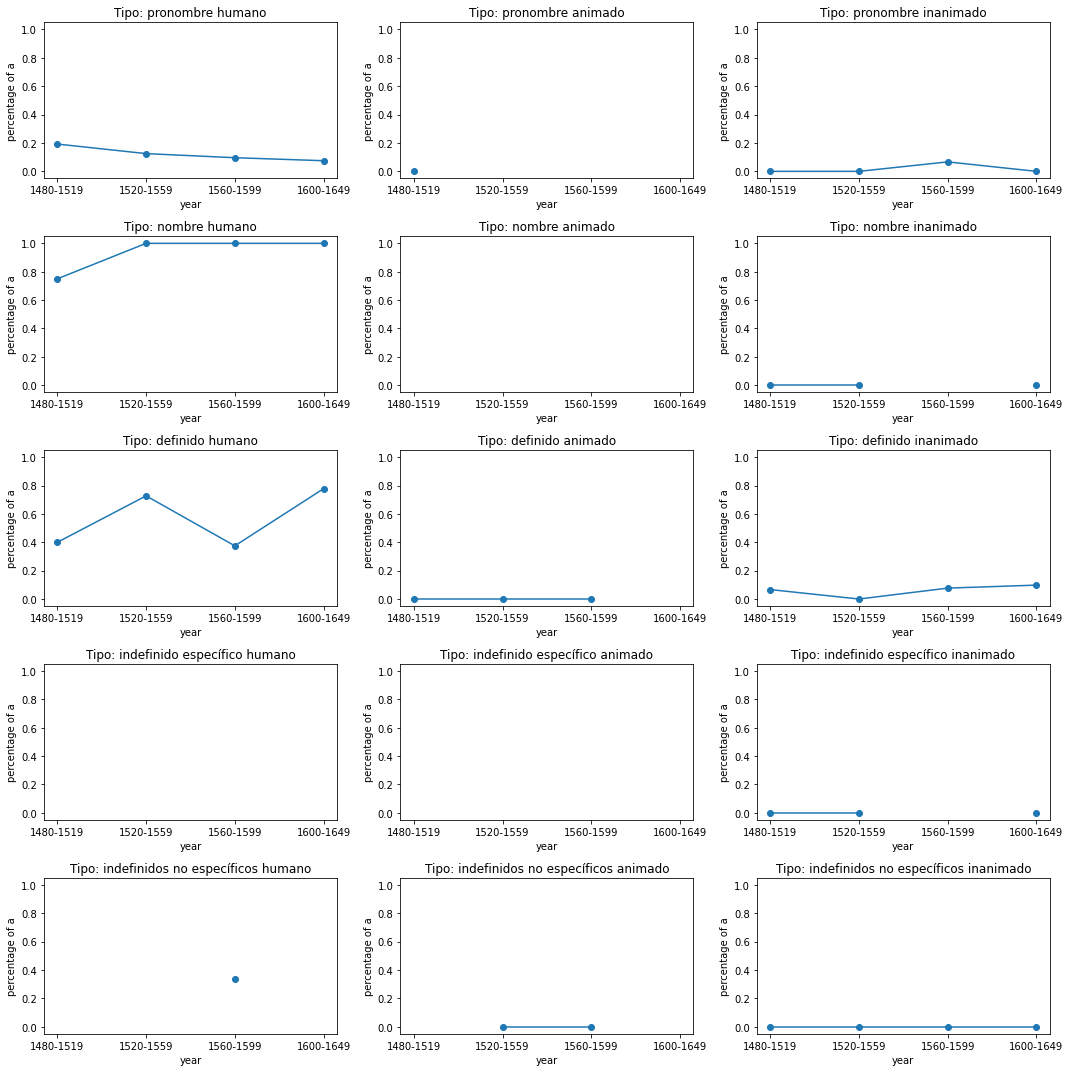

In [30]:
def plot_percentage_a(df, years, ranges=True):
    fig, axs = plt.subplots(len(definiteness_categories[:-1]), len(animacy_categories[:-1]), figsize=(15,15))
    
    dummy_data = [0.5 for year in years]
    
    for i, definiteness in enumerate(definiteness_categories[:-1]):
        for j, animacy in enumerate(animacy_categories[:-1]):
            array = []
            for year in years:
                #print(year)
                if ranges:
                    df_year = df[(df.loc[:, 'year'] >= year.start_year) & (df.loc[:, 'year'] <= year.end_year)]
                else:
                    df_year = df[df['year'] == year]
                
                
                # Check whether there is data
                percentage = calc_has_a_percentages(df_year, definiteness, animacy)
                array.append(percentage)
                
            axs[i,j].plot([str(year) for year in years], array, lw=1.5, marker = 'o')
            axs[i,j].scatter([str(year) for year in years], dummy_data, color='white', lw=1.5, marker = 'o')
            axs[i,j].title.set_text("Tipo: " + plot_mapping[definiteness] + " " + plot_mapping[animacy])
            axs[i,j].set(xlabel="year", ylabel="percentage of a")
            axs[i,j].set_ylim(-0.05, 1.05)
            #axs[i,j].set_xticks(labels=years)
            #plot()
    fig.tight_layout()
    return

plot_percentage_a(df, year_ranges)
                

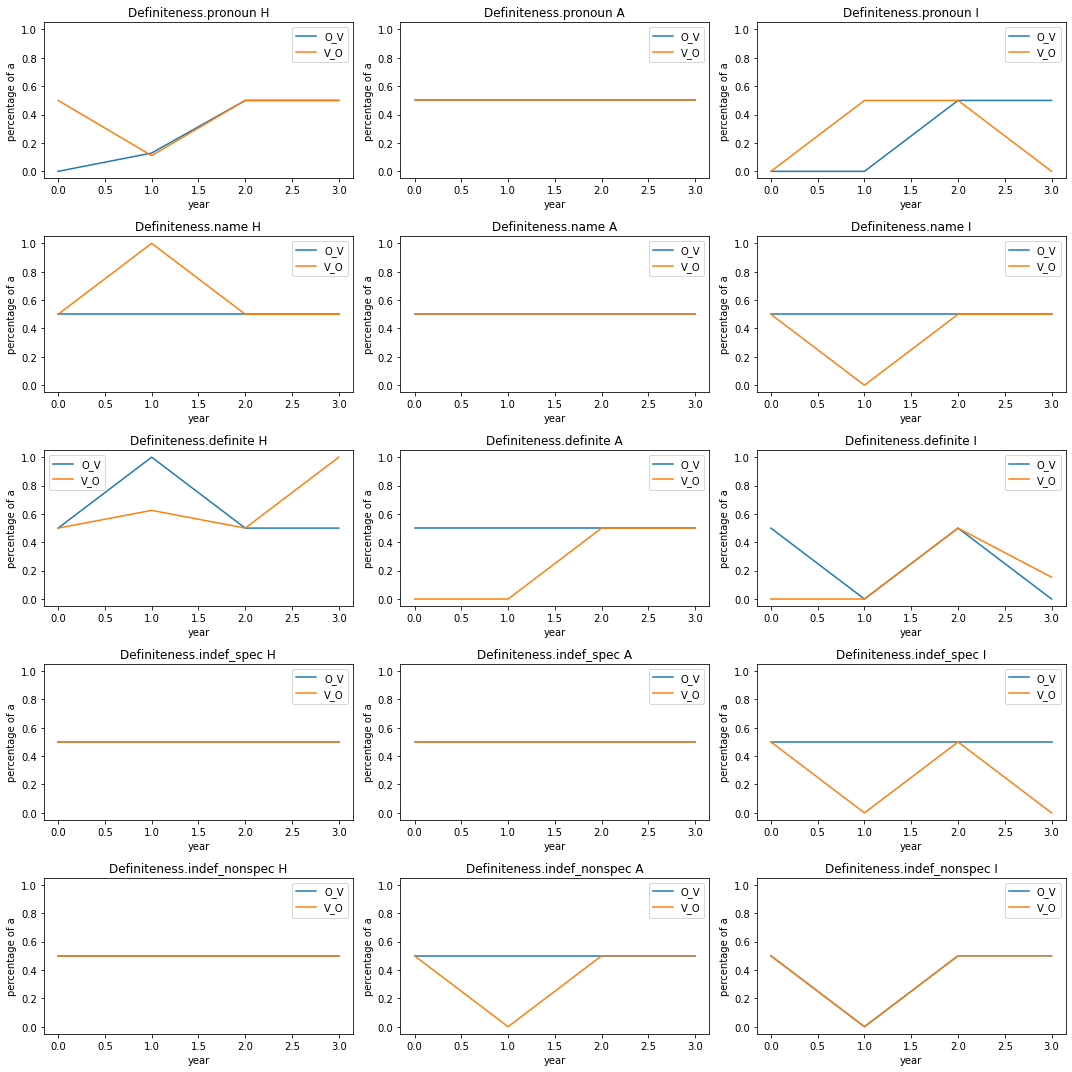

In [12]:
def select(year, VO: bool):
    if VO:
        condition = lambda item: isinstance(item, str) and item.index('O') > item.index('V')
    else:
        condition = lambda item: isinstance(item, str) and item.index('O') < item.index('V')
    return lambda df: (df['year'] >= year.start_year) & (df['year'] <= year.end_year) & (df['corrected_order'].apply(condition))

#block
def plot_all(df, years, ranges=True):
    fig, axs = plt.subplots(len(definiteness_categories[:-1]), len(animacy_categories[:-1]), figsize=(15,15))
    
    for i, definiteness in enumerate(definiteness_categories[:-1]):
        for j, animacy in enumerate(animacy_categories[:-1]):
            OVArray = []
            VOArray = []
            for year in years:
                #print(year)
                if ranges:
                    df_year_VO = df.loc[select(year, True), :]
                    df_year_OV = df.loc[select(year, False), :]
                else:
                    year_range = YearRange(year, year)
                    df_year_VO = df[select(year_range, True), :]
                    df_year_OV = df[select(year_range, False), :]
                VOArray.append(calc_has_a_percentages(df_year_VO, definiteness, animacy))
                OVArray.append(calc_has_a_percentages(df_year_OV, definiteness, animacy))
            axs[i,j].plot(OVArray, label="O_V")
            axs[i,j].plot(VOArray, label="V_O")
            axs[i,j].title.set_text(definiteness + " " + animacy)
            axs[i,j].set(xlabel="year", ylabel="percentage of a")
            axs[i,j].set_ylim(-0.05, 1.05)
            axs[i,j].legend()
            #axs[i,j].set_xticks(labels=years)
            #plot()
    fig.tight_layout()
    fig.savefig('img.png')
    return

plot_all(df, year_ranges)